In [1]:
from matplotlib import pyplot as plt

import os
os.chdir('/engram/nklab/hossein/recurrent_models/transformer_brain_encoder/')
!pwd

import numpy as np
from engine import evaluate, train_one_epoch
from tqdm import tqdm
from scipy.stats import pearsonr as corr
from sklearn.decomposition import IncrementalPCA, PCA
from sklearn.linear_model import LinearRegression

/engram/nklab/hossein/recurrent_models/transformer_brain_encoder


Test on Validation set 

100%|██████████| 20544/20544 [00:13<00:00, 1569.53it/s]
/home/ha2366/.conda/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ha2366/.conda/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


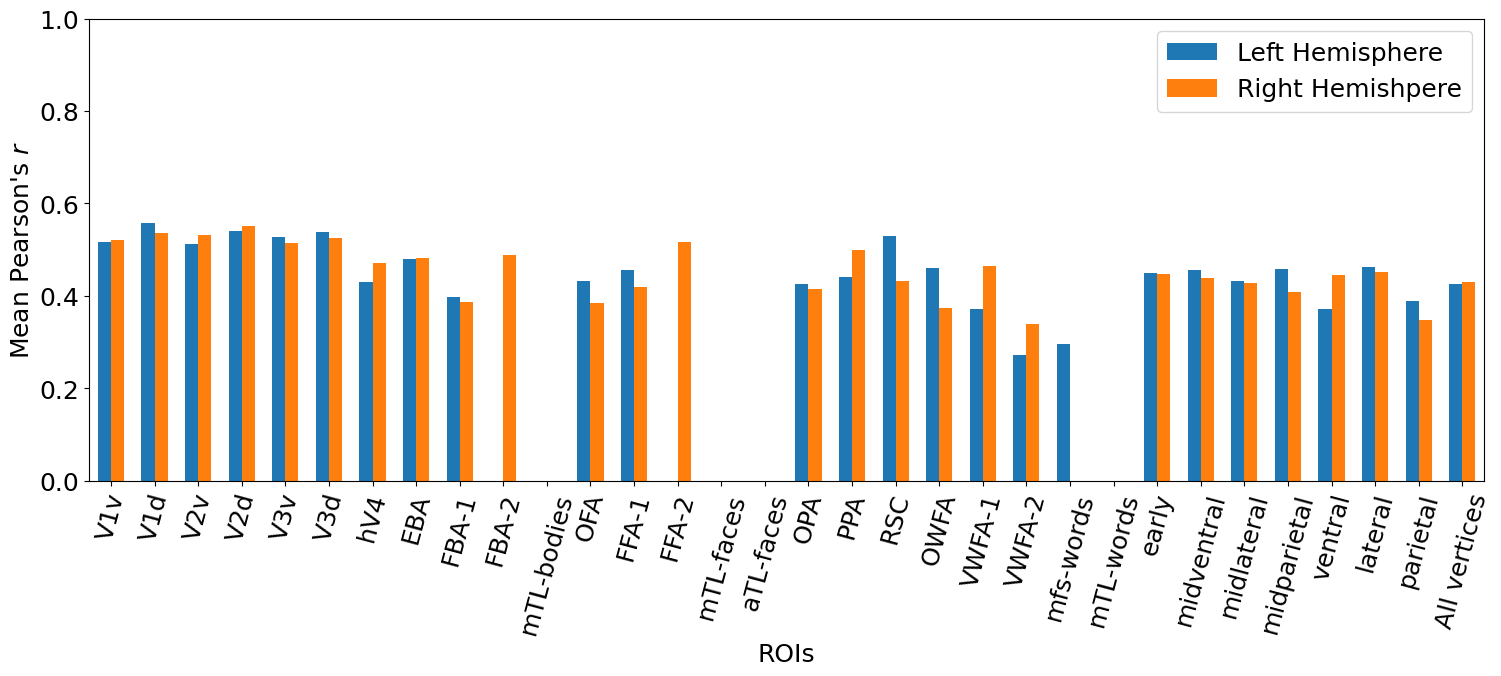

subj: 1   lh_corr: 0.4250829300599429   rh_corr: 0.42926552186146727
lh_corr_mean: 0.4250829300599429   rh_corr_mean: 0.42926552186146727


In [2]:
lh_corr = []
rh_corr = []

verbose = 1
plot_figs = 1 

data_dir = '../../../algonauts/algonauts_2023_challenge_data/'


for subj in [1]: # range(1,9):
    
    class argObj:
        def __init__(self, data_dir, subj):

            self.subj = format(subj, '02')
            self.data_dir = os.path.join(data_dir, 'subj'+self.subj)

    args = argObj(data_dir, subj)
    
    run = 1 

    feature_name = 'resnet50' #'dinov2_q_last'

    feature_dir = './saved_image_features/'
    subject_feature_dir =  os.path.join(feature_dir, feature_name,format(subj, '02'))
    save_dir = subject_feature_dir + '/pca_run' + str(run)
    idxs = np.load(save_dir + '/idxs.npy') 
    num_train = int(np.round(len(idxs) / 100 * 90))
    idxs_train, idxs_val = idxs[:num_train], idxs[num_train:] 

    features_train = np.load(save_dir + '/train.npy')
    features_val = np.load(save_dir + '/val.npy')
    features_test = np.load(save_dir + '/test.npy')

    fmri_dir = os.path.join(args.data_dir, 'training_split', 'training_fmri')
    lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
    rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

    lh_fmri_train = lh_fmri[idxs_train]
    lh_fmri_val = lh_fmri[idxs_val]
    rh_fmri_train = rh_fmri[idxs_train]
    rh_fmri_val = rh_fmri[idxs_val]

    # Fit linear regressions on the training data
    reg_lh = LinearRegression().fit(features_train, lh_fmri_train)
    reg_rh = LinearRegression().fit(features_train, rh_fmri_train)
    # Use fitted linear regressions to predict the validation and test fMRI data
    lh_fmri_val_pred = reg_lh.predict(features_val)
    lh_fmri_test_pred = reg_lh.predict(features_test)
    rh_fmri_val_pred = reg_rh.predict(features_val)
    rh_fmri_test_pred = reg_rh.predict(features_test)


    # Empty correlation array of shape: (LH vertices)
    lh_correlation = np.zeros(lh_fmri_val_pred.shape[1])
    # Correlate each predicted LH vertex with the corresponding ground truth vertex
    for v in tqdm(range(lh_fmri_val_pred.shape[1])):
        lh_correlation[v] = corr(lh_fmri_val_pred[:,v], lh_fmri_val[:,v])[0]

    # Empty correlation array of shape: (RH vertices)
    rh_correlation = np.zeros(rh_fmri_val_pred.shape[1])
    # Correlate each predicted RH vertex with the corresponding ground truth vertex
    for v in tqdm(range(rh_fmri_val_pred.shape[1])):
        rh_correlation[v] = corr(rh_fmri_val_pred[:,v], rh_fmri_val[:,v])[0]

        hemisphere = 'left' #@param ['left', 'right'] {allow-input: true}

    # Load the brain surface map of all vertices
    roi_dir = os.path.join(args.data_dir, 'roi_masks',
        hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
    fsaverage_all_vertices = np.load(roi_dir)


    # Load the ROI classes mapping dictionaries
    roi_mapping_files = ['mapping_prf-visualrois.npy', 'mapping_floc-bodies.npy',
        'mapping_floc-faces.npy', 'mapping_floc-places.npy',
        'mapping_floc-words.npy', 'mapping_streams.npy']
    roi_name_maps = []
    for r in roi_mapping_files:
        roi_name_maps.append(np.load(os.path.join(args.data_dir, 'roi_masks', r),
            allow_pickle=True).item())

    # Load the ROI brain surface maps
    lh_challenge_roi_files = ['lh.prf-visualrois_challenge_space.npy',
        'lh.floc-bodies_challenge_space.npy', 'lh.floc-faces_challenge_space.npy',
        'lh.floc-places_challenge_space.npy', 'lh.floc-words_challenge_space.npy',
        'lh.streams_challenge_space.npy']
    rh_challenge_roi_files = ['rh.prf-visualrois_challenge_space.npy',
        'rh.floc-bodies_challenge_space.npy', 'rh.floc-faces_challenge_space.npy',
        'rh.floc-places_challenge_space.npy', 'rh.floc-words_challenge_space.npy',
        'rh.streams_challenge_space.npy']
    lh_challenge_rois = []
    rh_challenge_rois = []
    for r in range(len(lh_challenge_roi_files)):
        lh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
            lh_challenge_roi_files[r])))
        rh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
            rh_challenge_roi_files[r])))

    # Select the correlation results vertices of each ROI
    roi_names = []
    lh_roi_correlation = []
    rh_roi_correlation = []
    for r1 in range(len(lh_challenge_rois)):
        for r2 in roi_name_maps[r1].items():
            if r2[0] != 0: # zeros indicate to vertices falling outside the ROI of interest
                roi_names.append(r2[1])
                lh_roi_idx = np.where(lh_challenge_rois[r1] == r2[0])[0]
                rh_roi_idx = np.where(rh_challenge_rois[r1] == r2[0])[0]
                lh_roi_correlation.append(lh_correlation[lh_roi_idx])
                rh_roi_correlation.append(rh_correlation[rh_roi_idx])
    roi_names.append('All vertices')
    lh_roi_correlation.append(lh_correlation)
    rh_roi_correlation.append(rh_correlation)

    # Create the plot
    lh_mean_roi_correlation = [np.mean(np.nan_to_num(np.array(lh_roi_correlation[r]), copy=True, nan=0.0, posinf=None, neginf=None))
        for r in range(len(lh_roi_correlation))]
    rh_mean_roi_correlation = [np.mean(np.nan_to_num(np.array(rh_roi_correlation[r]), copy=True, nan=0.0, posinf=None, neginf=None))
        for r in range(len(rh_roi_correlation))]

    plt.rcParams.update({'font.size': 18})

    if plot_figs:
        fig = plt.figure(figsize=(18,6))
        x = np.arange(len(roi_names))
        width = 0.30
        plt.bar(x - width/2, lh_mean_roi_correlation, width, label='Left Hemisphere')
        plt.bar(x + width/2, rh_mean_roi_correlation, width,
            label='Right Hemishpere')
        plt.xlim(left=min(x)-.5, right=max(x)+.5)
        plt.ylim(bottom=0, top=1)
        plt.xlabel('ROIs')
        plt.xticks(ticks=x, labels=roi_names, rotation=75)
        plt.ylabel('Mean Pearson\'s $r$')
        plt.legend(frameon=True, loc=1);
        plt.show()
        
        #fig.savefig('figures/detr_dino_8_visuals_16.pdf', format='pdf', bbox_inches="tight")
        #fig.savefig('figures/detr_dino_1_streams_inc_16.jpg', dpi=300, bbox_inches="tight")

    lh_corr.append(lh_mean_roi_correlation[-1])
    rh_corr.append(rh_mean_roi_correlation[-1])

    if verbose:
        print(f'subj: {subj}   lh_corr: {lh_mean_roi_correlation[-1]}   rh_corr: {rh_mean_roi_correlation[-1]}')


if verbose:
    print(f'lh_corr_mean: {np.array(lh_corr).mean()}   rh_corr_mean: {np.array(rh_corr).mean()}')

In [ ]:
features_train

/tmp/ipykernel_139293/1989635242.py:47: RuntimeWarning: Mean of empty slice
  lh_fsaverage = np.nanmean(lh_fsaverage, 0)
/tmp/ipykernel_139293/1989635242.py:48: RuntimeWarning: Mean of empty slice
  rh_fsaverage = np.nanmean(rh_fsaverage, 0)


Setting _INKSCAPE_GC=disable as a workaround for broken libgc
(process:210072): Gtk-WARNING **: 22:00:58.981: Locale not supported by C library.
	Using the fallback 'C' locale.
Unable to init server: Could not connect: Connection refused
(ld-linux-x86-64.so.2:210072): glibmm-WARNING **: 22:00:59.420: Failed to wrap object of type 'GtkRecentManager'. Hint: this error is commonly caused by failing to call a library init() function.
(ld-linux-x86-64.so.2:210072): Pango-CRITICAL **: 22:00:59.421: pango_font_get_hb_font: assertion 'PANGO_IS_FONT (font)' failed
(ld-linux-x86-64.so.2:210072): GLib-GObject-CRITICAL **: 22:00:59.421: g_object_unref: assertion 'G_IS_OBJECT (object)' failed
(ld-linux-x86-64.so.2:210072): Pango-CRITICAL **: 22:00:59.429: pango_font_get_hb_font: assertion 'PANGO_IS_FONT (font)' failed
(ld-linux-x86-64.so.2:210072): GLib-GObject-CRITICAL **: 22:00:59.429: g_object_unref: assertion 'G_IS_OBJECT (object)' failed
** (ld-linux-x86-64.so.2:210072): WARNING **: 22:00:59.4

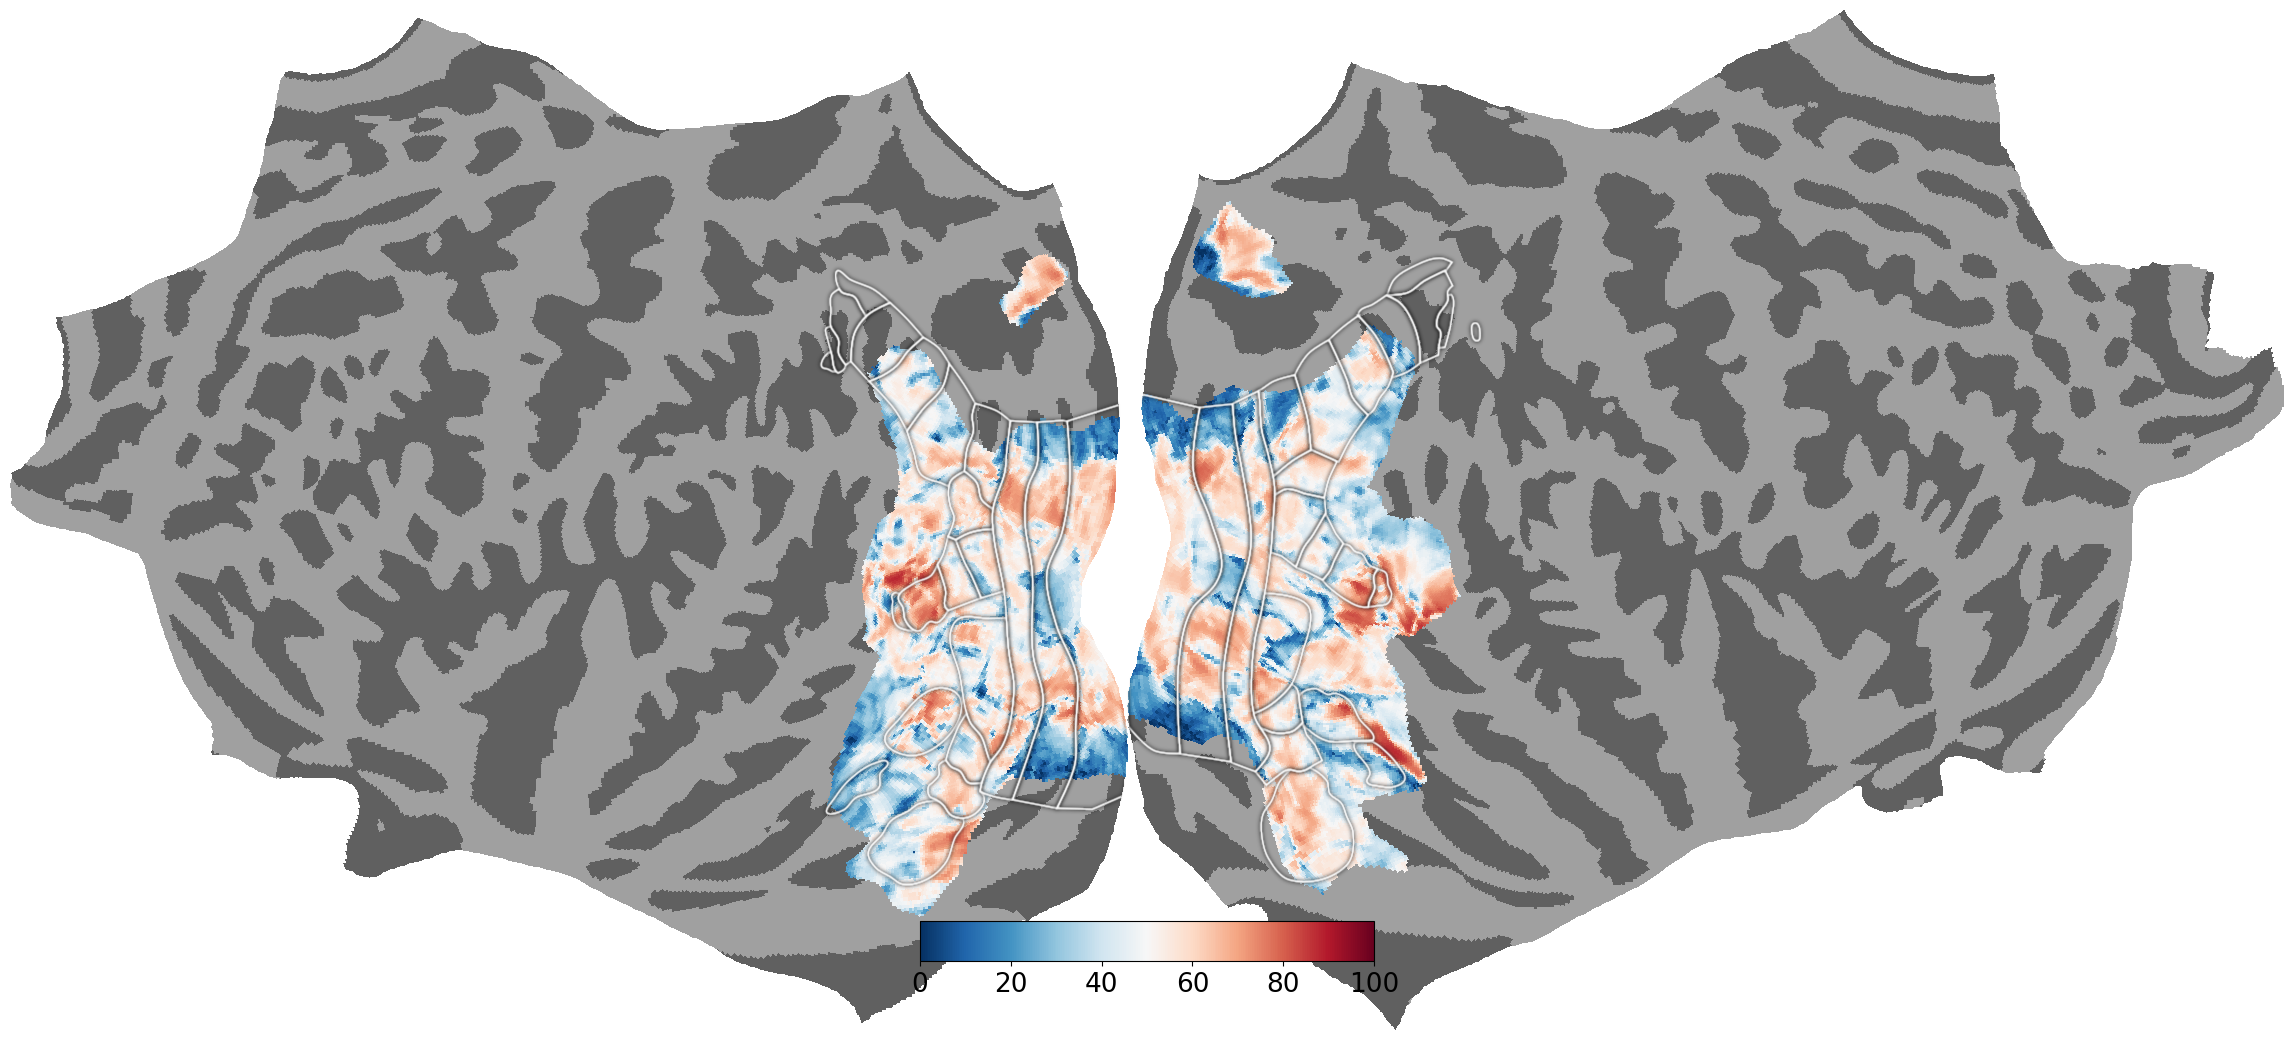

In [10]:
"""Plot data on a flattened brain surface using pycortex.

"""

import os
from copy import copy
import numpy as np
from matplotlib import pyplot as plt
import cortex
import cortex.polyutils

# =============================================================================
# Map the data to fsaverage space
# =============================================================================
# pycortex requires data in fsaverage space, so here you map the vertices from
# Challenge space into fsaverage space. The voxels not used in the Challenge
# are given NaN values, so that pycortex ignores them for the plotting.
# "ls_scores" and "rh_scores" are lists with 8 elements, one for each subject.
# These elements consist of vectors of length N, where N is the vertex amount
# for each subject and hemisphere, and each vector component consists of the
# prediction accuracy for that vertex.

#challenge_data_dir = '../algonauts_2023_challenge_data'
challenge_data_dir = '/engram/nklab/algonauts/algonauts_2023_challenge_data/'
lh_fsaverage = []
rh_fsaverage = []
subjects = [1]
for s, sub in enumerate(subjects):
    lh_mask_dir = os.path.join(challenge_data_dir, 'subj'+format(sub, '02'),
        'roi_masks', 'lh.all-vertices_fsaverage_space.npy')
    rh_mask_dir = os.path.join(challenge_data_dir, 'subj'+format(sub, '02'),
        'roi_masks', 'rh.all-vertices_fsaverage_space.npy')
    lh_fsaverage_all_vertices = np.load(lh_mask_dir)
    rh_fsaverage_all_vertices = np.load(rh_mask_dir)
    lh_fsavg = np.empty((len(lh_fsaverage_all_vertices)))
    lh_fsavg[:] = np.nan
    lh_fsavg[np.where(lh_fsaverage_all_vertices)[0]] = lh_correlation #lh_scores[s]
    lh_fsaverage.append(copy(lh_fsavg))
    rh_fsavg = np.empty((len(rh_fsaverage_all_vertices)))
    rh_fsavg[:] = np.nan
    rh_fsavg[np.where(rh_fsaverage_all_vertices)[0]] = rh_correlation #rh_scores[s]
    rh_fsaverage.append(copy(rh_fsavg))
    
    break

# Average the scores across subjects
lh_fsaverage = np.nanmean(lh_fsaverage, 0)
rh_fsaverage = np.nanmean(rh_fsaverage, 0)


# =============================================================================
# Plot parameters for colorbar
# =============================================================================
plt.rc('xtick', labelsize=19)
plt.rc('ytick', labelsize=19)


# =============================================================================
# Plot the results on brain surfaces
# =============================================================================
subject = 'fsaverage'
data = np.append(lh_fsaverage, rh_fsaverage) * 100
vertex_data = cortex.Vertex(data, subject, cmap='RdBu_r', vmin=0, vmax=100)
cortex.quickshow(vertex_data, with_curvature=True)
plt.savefig('my_plot.png', dpi=300) 
plt.show()



## Test on the test set

100%|██████████| 20544/20544 [00:12<00:00, 1687.94it/s]
/tmp/ipykernel_189419/1004425927.py:68: RuntimeWarning: divide by zero encountered in divide
  lh_correlation = np.clip(lh_correlation / lh_noise, a_max=1, a_min=0)
/tmp/ipykernel_189419/1004425927.py:69: RuntimeWarning: divide by zero encountered in divide
  rh_correlation = np.clip(rh_correlation / rh_noise, a_max=1, a_min=0)
/home/ha2366/.conda/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ha2366/.conda/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


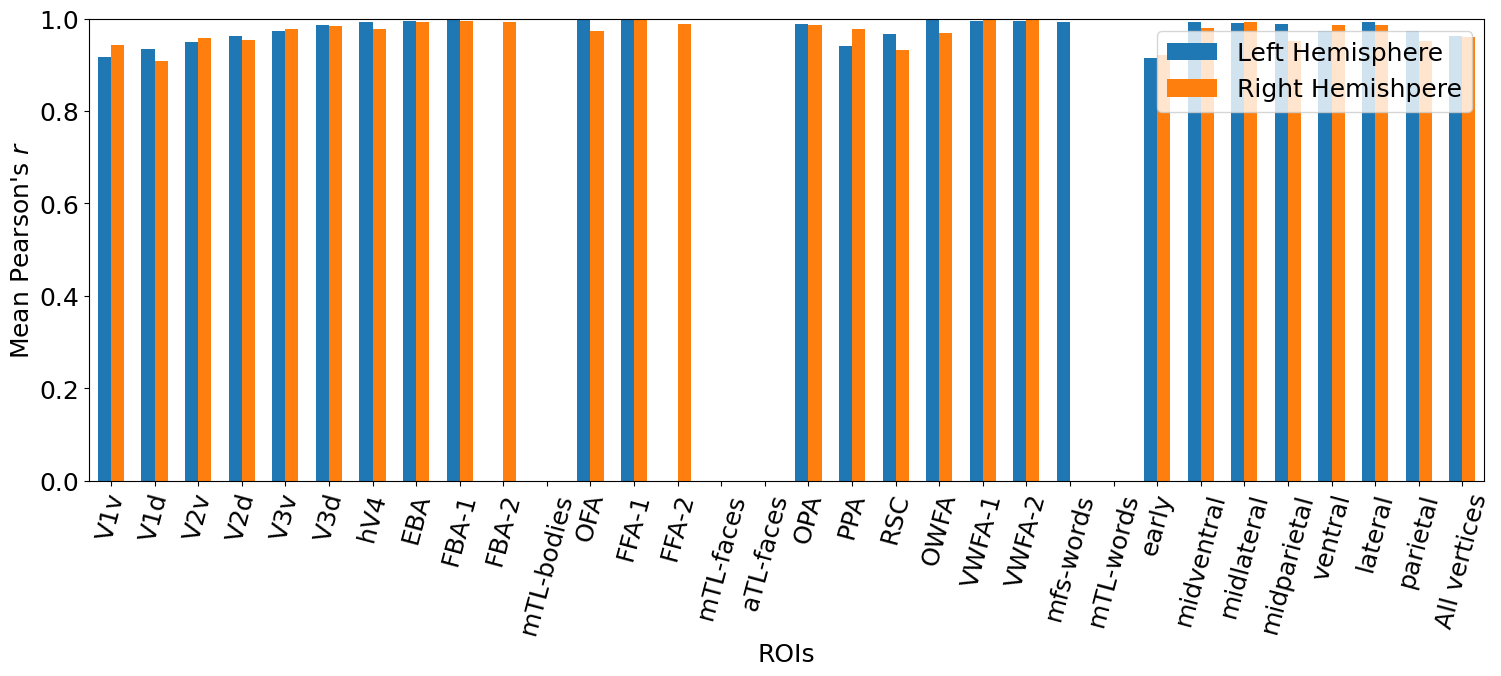

subj: 1   lh_corr: 0.9623829143464278   rh_corr: 0.9610585844499598
lh_corr_mean: 0.9623829143464278   rh_corr_mean: 0.9610585844499598


In [12]:
lh_corr = []
rh_corr = []

verbose = 1
plot_figs = 1 

data_dir = '../../../algonauts/algonauts_2023_challenge_data/'


for subj in [1]: # range(1,9):
    
    class argObj:
        def __init__(self, data_dir, subj):

            self.subj = format(subj, '02')
            self.data_dir = os.path.join(data_dir, 'subj'+self.subj)

    args = argObj(data_dir, subj)
    
    readout_res = 'streams_inc'  # [streams_inc', 'visuals', 'bodies', 'places', 'faces', 'words']
    enc_output_layer = 1
    run = 1  

    '''
    This model was trained using the following:

    python main.py --readout_res 'streams_inc' --save_model 1 --enc_output_layer 1
    '''

    subj_res_dir = f'./results/nsd_test/dinov2_q_transformer/subj_{args.subj}/{readout_res}/enc_{enc_output_layer}/run_{run}/'



    idxs = np.load(subj_res_dir + '/idxs.npy')  

    num_train = int(np.round(len(idxs) / 100 * 90))
    idxs_train, idxs_val = idxs[:num_train], idxs[num_train:]


    fmri_dir = os.path.join(args.data_dir, 'test_split', 'test_fmri')
    lh_fmri = np.load(os.path.join(fmri_dir, 'lh_test_fmri.npy'))
    rh_fmri = np.load(os.path.join(fmri_dir, 'rh_test_fmri.npy'))

    fmri_noise_dir = os.path.join(args.data_dir, 'test_split', 'noise_ceiling')
    lh_noise = np.load(os.path.join(fmri_noise_dir, 'lh_noise_ceiling.npy'))
    rh_noise = np.load(os.path.join(fmri_noise_dir, 'rh_noise_ceiling.npy'))

    # lh_fmri_train = lh_fmri[idxs_train]
    # lh_fmri_val = lh_fmri[idxs_val]
    # rh_fmri_train = rh_fmri[idxs_train]
    # rh_fmri_val = rh_fmri[idxs_val]

    lh_fmri_pred = np.load(subj_res_dir + 'lh_pred_test.npy')
    rh_fmri_pred = np.load(subj_res_dir + 'rh_pred_test.npy')

    # Empty correlation array of shape: (LH vertices)
    lh_correlation = np.zeros(lh_fmri_pred.shape[1])
    # Correlate each predicted LH vertex with the corresponding ground truth vertex
    for v in tqdm(range(lh_fmri_pred.shape[1])):
        lh_correlation[v] = corr(lh_fmri_pred[:,v], lh_fmri[:,v])[0]

    # Empty correlation array of shape: (RH vertices)
    rh_correlation = np.zeros(rh_fmri_pred.shape[1])
    # Correlate each predicted RH vertex with the corresponding ground truth vertex
    for v in tqdm(range(rh_fmri_pred.shape[1])):
        rh_correlation[v] = corr(rh_fmri_pred[:,v], rh_fmri[:,v])[0]


    # lh_correlation = np.clip(lh_correlation / lh_noise, a_max=1, a_min=0)
    # rh_correlation = np.clip(rh_correlation / rh_noise, a_max=1, a_min=0)

    hemisphere = 'left' #@param ['left', 'right'] {allow-input: true}

    # Load the brain surface map of all vertices
    roi_dir = os.path.join(args.data_dir, 'roi_masks',
        hemisphere[0]+'h.all-vertices_fsaverage_space.npy')
    fsaverage_all_vertices = np.load(roi_dir)


    # Load the ROI classes mapping dictionaries
    roi_mapping_files = ['mapping_prf-visualrois.npy', 'mapping_floc-bodies.npy',
        'mapping_floc-faces.npy', 'mapping_floc-places.npy',
        'mapping_floc-words.npy', 'mapping_streams.npy']
    roi_name_maps = []
    for r in roi_mapping_files:
        roi_name_maps.append(np.load(os.path.join(args.data_dir, 'roi_masks', r),
            allow_pickle=True).item())

    # Load the ROI brain surface maps
    lh_challenge_roi_files = ['lh.prf-visualrois_challenge_space.npy',
        'lh.floc-bodies_challenge_space.npy', 'lh.floc-faces_challenge_space.npy',
        'lh.floc-places_challenge_space.npy', 'lh.floc-words_challenge_space.npy',
        'lh.streams_challenge_space.npy']
    rh_challenge_roi_files = ['rh.prf-visualrois_challenge_space.npy',
        'rh.floc-bodies_challenge_space.npy', 'rh.floc-faces_challenge_space.npy',
        'rh.floc-places_challenge_space.npy', 'rh.floc-words_challenge_space.npy',
        'rh.streams_challenge_space.npy']
    lh_challenge_rois = []
    rh_challenge_rois = []
    for r in range(len(lh_challenge_roi_files)):
        lh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
            lh_challenge_roi_files[r])))
        rh_challenge_rois.append(np.load(os.path.join(args.data_dir, 'roi_masks',
            rh_challenge_roi_files[r])))

    # Select the correlation results vertices of each ROI
    roi_names = []
    lh_roi_correlation = []
    rh_roi_correlation = []
    for r1 in range(len(lh_challenge_rois)):
        for r2 in roi_name_maps[r1].items():
            if r2[0] != 0: # zeros indicate to vertices falling outside the ROI of interest
                roi_names.append(r2[1])
                lh_roi_idx = np.where(lh_challenge_rois[r1] == r2[0])[0]
                rh_roi_idx = np.where(rh_challenge_rois[r1] == r2[0])[0]
                lh_roi_correlation.append(lh_correlation[lh_roi_idx])
                rh_roi_correlation.append(rh_correlation[rh_roi_idx])
    roi_names.append('All vertices')
    lh_roi_correlation.append(lh_correlation)
    rh_roi_correlation.append(rh_correlation)

    # Create the plot
    lh_mean_roi_correlation = [np.mean(np.nan_to_num(np.array(lh_roi_correlation[r]), copy=True, nan=0.0, posinf=None, neginf=None))
        for r in range(len(lh_roi_correlation))]
    rh_mean_roi_correlation = [np.mean(np.nan_to_num(np.array(rh_roi_correlation[r]), copy=True, nan=0.0, posinf=None, neginf=None))
        for r in range(len(rh_roi_correlation))]

    plt.rcParams.update({'font.size': 18})

    if plot_figs:
        fig = plt.figure(figsize=(18,6))
        x = np.arange(len(roi_names))
        width = 0.30
        plt.bar(x - width/2, lh_mean_roi_correlation, width, label='Left Hemisphere')
        plt.bar(x + width/2, rh_mean_roi_correlation, width,
            label='Right Hemishpere')
        plt.xlim(left=min(x)-.5, right=max(x)+.5)
        plt.ylim(bottom=0, top=1)
        plt.xlabel('ROIs')
        plt.xticks(ticks=x, labels=roi_names, rotation=75)
        plt.ylabel('Mean Pearson\'s $r$')
        plt.legend(frameon=True, loc=1);
        plt.show()
        
        #fig.savefig('figures/detr_dino_8_visuals_16.pdf', format='pdf', bbox_inches="tight")
        #fig.savefig('figures/detr_dino_1_streams_inc_16.jpg', dpi=300, bbox_inches="tight")

    lh_corr.append(lh_mean_roi_correlation[-1])
    rh_corr.append(rh_mean_roi_correlation[-1])

    if verbose:
        print(f'subj: {subj}   lh_corr: {lh_mean_roi_correlation[-1]}   rh_corr: {rh_mean_roi_correlation[-1]}')


if verbose:
    print(f'lh_corr_mean: {np.array(lh_corr).mean()}   rh_corr_mean: {np.array(rh_corr).mean()}')

In [13]:
lh_noise.shape

(19004,)

In [11]:
np.clip(lh_correlation / lh_noise, a_max=1, a_min=0)

/tmp/ipykernel_189419/1153093882.py:1: RuntimeWarning: divide by zero encountered in divide
  np.clip(lh_correlation / lh_noise, a_max=1, a_min=0)


array([1.        , 0.83799336, 0.97925566, ..., 0.78614328, 0.87802989,
       1.        ])

In [4]:
import gi
gi.require_version('Pango', '1.0')
from gi.repository import Pango

font_desc = Pango.FontDescription("Arial 12")
#font = Pango.Font.from_description(font_desc)
print(font_desc)  # This should not raise any errors



<Pango.FontDescription object at 0x2ad798a03dc0 (PangoFontDescription at 0x9b42fd0)>


In [5]:
stop

NameError: name 'stop' is not defined

In [ ]:
import gi
gi.require_version('Pango', '1.0')
from gi.repository import Pango

def test_pango():
    try:
        font_description = Pango.FontDescription("Arial 24")
        print("Pango initialized with font:", font_description.to_string())
    except Exception as e:
        print("Error with Pango:", e)

test_pango()


In [ ]:
import gi

gi.require_version('Pango', '1.0')
from gi.repository import Pango

# Get the list of fonts
font_families = Pango.FontFamily
for family in font_families:
    print(family.get_name())



In [ ]:
font_families

In [ ]:
import gi
gi.require_version('Gtk', '3.0')
gi.require_version('Pango', '1.0')
#gi.require_version('Cairo', '1.0')
from gi.repository import Gtk, Pango, Gdk

class FontTestWindow(Gtk.Window):
    def __init__(self):
        super().__init__(title="Font Test")
        self.set_default_size(300, 200)

        # Create a drawing area
        self.drawing_area = Gtk.DrawingArea()
        self.drawing_area.connect("draw", self.on_draw)
        self.add(self.drawing_area)

    def on_draw(self, widget, cr):
        cr.set_source_rgb(1, 1, 1)  # Set background color (white)
        cr.paint()

        cr.set_source_rgb(0, 0, 0)  # Set text color (black)

        # Set font properties
        font_description = Pango.FontDescription("Arial 24")
        cr.select_font_face("Arial", Cairo.FONT_SLANT_NORMAL, Cairo.FONT_WEIGHT_NORMAL)
        cr.set_font_size(24)

        # Show text
        cr.move_to(10, 50)
        cr.show_text("Testing Arial Font")

        # Finish drawing
        cr.stroke()

# if __name__ == "__main__":
window = FontTestWindow()
window.connect("destroy", Gtk.main_quit)
window.show_all()
Gtk.main()